In [39]:
# Created on Feb 2020
# Author: 임일
import os
import numpy as np
import pandas as pd

# 필요한 Surprise 알고리즘 불러오기
from surprise import BaselineOnly 
from surprise import KNNWithMeans, KNNBaseline, KNNBasic
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [174]:
path = './../../../data/rotten_tomato/graph/'
os.listdir(path)

['emotion_analysis_data',
 'final_rating(sentiment,emotion).csv',
 'graph',
 'model.pth',
 'model_new.pth',
 'model_rotten.pth',
 'model_save',
 'movie1_neg.txt',
 'movie1_pos.txt',
 'movie2_neg.txt',
 'movie2_pos.txt',
 'movie3_neg.txt',
 'movie3_pos.txt',
 'rotten_movie_table.csv',
 'rotten_rating(review_100_user).csv',
 'rotten_rating_review_emotion_table.csv',
 'rotten_rating_review_emotion_table.xlsx',
 'rotten_rating_review_sentiment_table.csv',
 'rotten_rating_review_sentiment_table.xlsx',
 'rotten_rating_review_table.csv',
 'rotten_review_scaled_clean.csv',
 'rotten_review_scaled_label(pos,neu,neg).csv',
 'rotten_review_scaled_label.csv',
 'rotten_review_scaled_new.csv',
 'rotten_tomatoes_critic_reviews.csv',
 'rotten_tomatoes_movies.csv',
 'rotten_user_table.csv',
 'sentiment_analysis_data',
 'testset.csv',
 'trainset.csv']

In [209]:
# csv 파일에서 불러오기
# r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df = pd.read_csv(path + 'final_rating(sentiment,emotion).csv')

In [210]:
ratings_df = ratings_df[['user_id', 'movie_id', 'review_score' , 'sentiment', 'emotion', 'review_date']]

In [211]:
ratings_df['origin_rating'] = ratings_df.review_score * 4.5 + 0.5

In [212]:
# 소수점 0.5 단위로 반내림
scaled_rating = list()

for val in ratings_df.origin_rating:
    remainder = 0
    if val % 0.5 != 0.0:
        remainder = val % 0.5
    scaled_rating.append(val - remainder)

In [213]:
set(scaled_rating)

{0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [214]:
ratings_df['rating'] = scaled_rating

In [215]:
ratings_df.head()

,user_id,movie_id,review_score,sentiment,emotion,review_date,origin_rating,rating
0,943,0,0.70,2,2,2010-02-09,3.650,3.5
1,7242,0,0.25,0,2,2010-02-10,1.625,1.5
2,1046,0,0.70,3,2,2010-02-10,3.650,3.5
3,4895,0,0.70,4,2,2010-02-10,3.650,3.5
4,4517,0,0.60,1,2,2010-02-10,3.200,3.0


### 1. 20개 이상의 리뷰 남긴 User

In [216]:
group = ratings_df.groupby('user_id')
group_user_id = group['movie_id'].count()

In [217]:
def cal_rate(num, total, limit, condition):
    if condition == 'low':
        print(f"{limit}개 미만: {sum(num < limit)}, {round((sum(num < limit)/total),2)*100}%")
        return sum(num >= limit)
    
    if condition == 'high':
        print(f"{limit}개 이상: {sum(num >= limit)}, {round((sum(num > limit)/total),2)*100}%")
        return sum(num >= limit)

In [218]:
num = group_user_id.sort_values()
total = len(group_user_id)

condition = 'high'
sample_num = cal_rate(num, total, 20, condition)
# sample_num = cal_rate(num, total, 100, condition)
# sample_num = cal_rate(num, total, 500, condition)

20개 이상: 2994, 30.0%


In [219]:
group_user_id.sort_values(ascending=False)[:5]

user_id
2600    6486
8148    6356
3265    5300
2495    5212
3926    4548
Name: movie_id, dtype: int64

In [220]:
sample = group_user_id.sort_values(ascending=False)[:sample_num]
total = len(group_user_id)

In [221]:
len(sample)

2994

In [222]:
sample.index

Int64Index([2600, 8148, 3265, 2495, 3926, 5446, 5716, 7603, 7917, 1738,
            ...
            5685, 5990, 7188, 6088, 6733, 9250, 4203, 7911, 4540, 1743],
           dtype='int64', name='user_id', length=2994)

In [223]:
# 특정 인덱스에 해당하는 행(리뷰 100개 이상 남긴 유저)만 필터링
df = ratings_df[ratings_df['user_id'].isin(list(sample.index))]

In [224]:
df.shape

(721094, 8)

In [225]:
df.to_csv(path+'rotten_rating(review_20_user).csv', index=False)
# df.to_csv(path+'rotten_rating(review_100_user).csv', index=False)

### 2. 평점 파일 로드하기(리뷰 20 이상)

In [226]:
path = './../../../data/rotten_tomato/'
ratings_df = pd.read_csv(path + 'rotten_rating(review_20_user).csv')
# ratings_df = pd.read_csv(path + 'rotten_rating(review_100_user).csv')

In [227]:
ratings_df.head()

,user_id,movie_id,review_score,sentiment,emotion,review_date,origin_rating,rating
0,7242,0,0.25,0,2,2010-02-10,1.625,1.5
1,1046,0,0.70,3,2,2010-02-10,3.650,3.5
2,4895,0,0.70,4,2,2010-02-10,3.650,3.5
3,4517,0,0.60,1,2,2010-02-10,3.200,3.0
4,6226,0,0.80,4,2,2010-02-10,4.100,4.0


In [228]:
ratings_df['review_date'] = pd.to_datetime(ratings_df.review_date)

In [229]:
ratings_df.isnull().sum()

user_id          0
movie_id         0
review_score     0
sentiment        0
emotion          0
review_date      0
origin_rating    0
rating           0
dtype: int64

In [230]:
# 날짜 별로 정렬
ratings_df.sort_values(by='review_date', inplace=True)

In [231]:
ratings_df.head()

,user_id,movie_id,review_score,sentiment,emotion,review_date,origin_rating,rating
73212,7403,2494,1.00,3,4,1800-01-01,5.000,5.0
18569,6220,970,0.20,1,2,1800-01-01,1.400,1.0
257862,9296,7594,0.60,4,2,1800-01-01,3.200,3.0
304601,7403,8800,0.70,4,2,1800-01-01,3.650,3.5
392395,2343,11205,0.25,0,5,1800-01-01,1.625,1.5


In [232]:
# from sklearn.model_selection import train_test_split
# trainset, testset, _, _ = train_test_split(ratings_df, ratings_df, test_size=0.3, random_state=24)

### 3. dataset 분할시 cold-start problem case 분리

In [233]:
ratings_df.shape

(721094, 8)

In [234]:
_test_ratio = 0.7 # test set 비율
num_test = int(np.ceil(ratings_df.shape[0] * _test_ratio))

In [235]:
trainset = ratings_df.iloc[:-num_test]
testset  = ratings_df.iloc[-num_test:]

print(f"trainset 개수: {len(trainset)}")
print(f"testset 개수: {len(testset)}")

trainset 개수: 216328
testset 개수: 504766


In [236]:
trainset_user_id = set(trainset.user_id)
trainset_movie_id = set(trainset.movie_id)
print(f"trainset user: {len(trainset_user_id)}")
print(f"trainset movie: {len(trainset_movie_id)}")

testset_user_id = set(testset.user_id)
testset_movie_id = set(testset.movie_id)
print(f"testset user: {len(testset_user_id)}")
print(f"testset movie: {len(testset_movie_id)}")

trainset user: 1112
trainset movie: 8521
testset user: 2732
testset movie: 15846


In [237]:
intersection_user_id = trainset_user_id.intersection(testset_user_id)
intersection_movie_id = trainset_movie_id.intersection(testset_movie_id)
print(f"교집합 user_id: {len(intersection_user_id)}")
print(f"교집합 movie_id: {len(intersection_movie_id)}")

difference_user_id = testset_user_id.difference(trainset_user_id)
difference_movie_id = testset_movie_id.difference(trainset_movie_id)
print(f"차집합 user_id: {len(difference_user_id)}") # testset에만 있는 user_id
print(f"차집합 movie_id: {len(difference_movie_id)}")

교집합 user_id: 850
교집합 movie_id: 6805
차집합 user_id: 1882
차집합 movie_id: 9041


#### 3-1. testset에서 교집합 user_id, movie_id 데이터만 추출

In [238]:
condition_inter_user  = testset['user_id'].isin(intersection_user_id)
condition_inter_movie = testset['movie_id'].isin(intersection_movie_id)

In [239]:
sum(condition_inter_user & condition_inter_movie)

28766

In [240]:
filtered_testset = testset[condition_inter_user & condition_inter_movie].copy()

In [241]:
filtered_testset

,user_id,movie_id,review_score,sentiment,emotion,review_date,origin_rating,rating
224104,8557,6677,0.70,3,0,2007-06-30,3.650,3.5
224108,5108,6677,0.70,3,2,2007-06-30,3.650,3.5
224105,2487,6677,0.75,3,2,2007-06-30,3.875,3.5
224106,6613,6677,0.60,4,2,2007-06-30,3.200,3.0
441976,8103,12292,0.70,4,2,2007-06-30,3.650,3.5
...,...,...,...,...,...,...,...,...
691624,2495,16971,1.00,4,2,2020-10-20,5.000,5.0
179452,2495,5423,0.75,3,2,2020-10-21,3.875,3.5
523039,7229,13424,0.60,3,2,2020-10-21,3.200,3.0
523040,7229,13424,0.60,3,2,2020-10-21,3.200,3.0


#### 3-2. testset에서 차집합 user_id, movie_id 데이터만 추출 (cold-start용)

In [242]:
condition_differ_user  = testset['user_id'].isin(difference_user_id)
condition_differ_movie = testset['movie_id'].isin(difference_movie_id)

In [243]:
removed_testset = testset[condition_inter_user | condition_inter_movie].copy()

In [244]:
removed_testset

,user_id,movie_id,review_score,sentiment,emotion,review_date,origin_rating,rating
224104,8557,6677,0.70,3,0,2007-06-30,3.650,3.5
224108,5108,6677,0.70,3,2,2007-06-30,3.650,3.5
224105,2487,6677,0.75,3,2,2007-06-30,3.875,3.5
224106,6613,6677,0.60,4,2,2007-06-30,3.200,3.0
441976,8103,12292,0.70,4,2,2007-06-30,3.650,3.5
...,...,...,...,...,...,...,...,...
634378,3287,15479,0.70,2,2,2020-10-26,3.650,3.5
640084,7172,15624,0.60,4,2,2020-10-27,3.200,3.0
578588,7172,14239,0.50,2,2,2020-10-27,2.750,2.5
714638,6432,17562,0.75,2,2,2020-10-28,3.875,3.5


In [247]:
len(filtered_testset) / len(trainset)

0.13297400244073815

In [248]:
trainset

,user_id,movie_id,review_score,sentiment,emotion,review_date,origin_rating,rating
73212,7403,2494,1.000,3,4,1800-01-01,5.0000,5.0
18569,6220,970,0.200,1,2,1800-01-01,1.4000,1.0
257862,9296,7594,0.600,4,2,1800-01-01,3.2000,3.0
304601,7403,8800,0.700,4,2,1800-01-01,3.6500,3.5
392395,2343,11205,0.250,0,5,1800-01-01,1.6250,1.5
...,...,...,...,...,...,...,...,...
671667,9095,16446,1.000,4,2,2007-06-30,5.0000,5.0
671668,1045,16446,0.800,3,2,2007-06-30,4.1000,4.0
210566,8391,6288,0.400,3,2,2007-06-30,2.3000,2.0
210567,6158,6288,0.300,1,4,2007-06-30,1.8500,1.5


#### 3-3. trainset, testset 저장 (GCMC 데이터용)

In [249]:
trainset.to_csv(path+'trainset_filtered.csv', index=False)
filtered_testset.to_csv(path+'testset_filtered.csv', index=False)
removed_testset.to_csv(path+'testset_removed.csv', index=False)
# testset.to_csv(path+'testset.csv', index=False)

### 4. Surprise 알고리즘

- DF Load

In [26]:
path = './../../../data/rotten_tomato/graph/'
os.listdir(path)

['dummies_actors.npy',
 'dummies_audience_status.npy',
 'dummies_content_rating.npy',
 'dummies_directors.npy',
 'dummies_genres.npy',
 'dummies_production_company.npy',
 'dummies_tomatometer_status.npy',
 'emotion_1.csv',
 'movie_features.npy',
 'rating_1.csv',
 'rotten_tomatoes_movies.csv',
 'rotten_user_table.csv',
 'sentiment_1.csv',
 'testset.csv',
 'trainset.csv',
 'user_features.npy']

In [260]:
trainset = pd.read_csv(os.path.join(path, 'trainset_filtered.csv'), encoding='utf-8')
testset = pd.read_csv(os.path.join(path, 'testset_filtered.csv'), encoding='utf-8')

In [261]:
trainset.shape

(216328, 8)

In [262]:
testset.shape

(28766, 8)

In [263]:
trainset = trainset[['user_id','movie_id','rating']]
testset = testset[['user_id','movie_id','rating']]

- Surprise 데이터 형태 변형

In [264]:
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(trainset, reader)
surprise_trainset = data.build_full_trainset()

In [265]:
len(trainset)

216328

In [266]:
len(testset)

28766

In [267]:
records = testset.to_records(index=False)
surprise_testset = list(records)

In [268]:
# 정확도 계산 
algo = KNNWithMeans()
algo.fit(surprise_trainset)
predictions = algo.test(surprise_testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9232


0.9232191431103604

- CF(User-based)

In [269]:
sim_options = {'name': 'pearson_baseline',
               'user_based': True}
algo = KNNBaseline(k=10, sim_options=sim_options)
algo.fit(surprise_trainset)
predictions = algo.test(surprise_testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8753


0.8753288760469986

- CF(Item-based)

In [270]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False}
algo = KNNBaseline(k=10, sim_options=sim_options)
algo.fit(surprise_trainset)
predictions = algo.test(surprise_testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9099


0.9098595758850381

### 0. Timer

In [271]:
import time
import datetime

In [272]:
# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [273]:
start_time = time.time()
print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

  Training epoch took: 0:00:00


## 여러 알고리즘 고려

In [274]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
# from sklearn.model_selection import cross_validate 사이킷런의 크로스벨리데이션이 아니다.
from surprise.model_selection import cross_validate

In [275]:
start_time = time.time()

# 알고리즘 비교
algorithms = [SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering]
names = []
results = []
for option in algorithms:
    algo = option()
    names.append(option.__name__)       # 알고리즘 이름 
    algo.fit(surprise_trainset)
    predictions = algo.test(surprise_testset)
    results.append(accuracy.rmse(predictions))
# names = np.array(names)
# results = np.array(results)

print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

RMSE: 0.8469
RMSE: 0.8270


C:\Users\user\AppData\Local\Temp/ipykernel_7704/2595687920.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(surprise_trainset)


RMSE: 0.9273
RMSE: 0.9056
RMSE: 1.4758
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8726
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8519
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9232
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9168
Estimating biases using als...
RMSE: 0.8485
RMSE: 0.9538
  Training epoch took: 0:31:27


In [33]:
names = np.array(names)
results = np.array(results)

array([0.71399383, 0.71695488, 0.71990512, 0.72800815, 0.72940057,
       0.73280625, 0.73628146, 0.73950474, 0.74244314, 0.80956118,
       1.38812599])

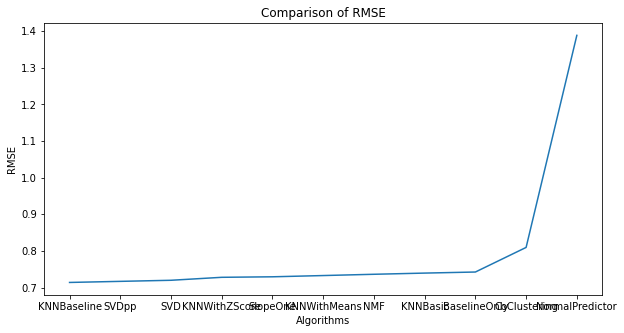

In [34]:
# 결과를 그래프로 표시
import matplotlib.pyplot as plt
index = np.argsort(results)
# plt.ylim(0.5, 0.8)
fig = plt.figure(figsize = (10,5))
plt.plot(names[index], results[index])
plt.xlabel('Algorithms')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE')
results[index]

### 1. Algorithms

In [57]:
start_time = time.time()

# 알고리즘 비교
algorithms = [SVD, SVDpp]
names = []
results = []
for option in algorithms:
    algo = option()
    names.append(option.__name__)       # 알고리즘 이름 
    algo.fit(surprise_trainset)
    predictions = algo.test(surprise_testset)
    results.append(accuracy.rmse(predictions))
# names = np.array(names)
# results = np.array(results)

print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

RMSE: 0.7189
RMSE: 0.7173
  Training epoch took: 1:34:44


- Item-based

In [60]:
# 알고리즘 옵션 변경, 정확도 계산
names.append('CF(Item-based)')
sim_options = {'name': 'pearson_baseline',
               'user_based': False}
algo = KNNBasic(k=10, sim_options=sim_options)
algo.fit(surprise_trainset)
predictions = algo.test(surprise_testset)
results.append(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8396


- User-based

In [61]:
# 알고리즘 옵션 변경, 정확도 계산
names.append('CF(User-based)')
sim_options = {'name': 'pearson_baseline',
               'user_based': True}
algo = KNNBaseline(k=10, sim_options=sim_options)
algo.fit(surprise_trainset)
predictions = algo.test(surprise_testset)
results.append(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.6984


In [62]:
names = np.array(names)
results = np.array(results)

array([0.69839673, 0.71728678, 0.71893383, 0.83958707])

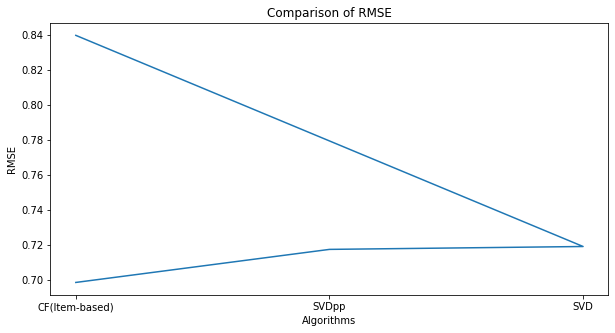

In [63]:
# 결과를 그래프로 표시
import matplotlib.pyplot as plt
index = np.argsort(results)
# plt.ylim(0.5, 0.8)
fig = plt.figure(figsize = (10,5))
plt.plot(names[index], results[index])
plt.xlabel('Algorithms')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE')
results[index]

### 2. MF

- SVD

In [102]:
start_time = time.time()

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

RMSE: 0.8201
  Training epoch took: 0:00:00


- SVD++

In [103]:
start_time = time.time()

algo = SVDpp()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

RMSE: 0.8077
  Training epoch took: 0:00:00
